# Building Neuron Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

Neurons are the most basic components in neural dynamics simulation. In BrainPy, `brainpy.NeuGroup` is used for neuron group modeling. **All types of neural groups, build-in or user-customized, should inherit the `brainpy.NeuGroup` base class.**

## brainpy.NeuGroup

When defining a neural group class, the `size` of the neural group should be speficied in initialization. `size` can be a integer referring to the number of neurons or a tuple/list of integers referring to the geometry of the neural group in different dimensions.

While providing a flexible framework to realize various kinds of neurons, the `brianpy.NeuGroup` requires users to implement the `update(_t, dt)` function to update the neural group state during dymamics simulation.

In the following part, a [Hodgkin-Huxley](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.HH.html) (HH) model is used as an example for illustration.

### [Hodgkin–Huxley (HH) Model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.HH.html)

The Hodgkin-Huxley (HH) model for the generation of the nerve action potential is one of the most successful mathematical models of a complex biological process that has ever been formulated.Mathematically, the model is given by:

$$
\begin{aligned}
    C_m \frac {dV} {dt} = -(\bar{g}_{Na} m^3 h (V &-E_{Na})
    + \bar{g}_K n^4 (V-E_K) + g_{leak} (V - E_{leak})) + I(t) \quad\quad(1) \\
    \frac {dx} {dt} &= \alpha_x (1-x)  - \beta_x, \quad x\in {\rm{\{m, h, n\}}} \quad\quad(2) \\
    &\alpha_m(V) = \frac {0.1(V+40)}{1-\exp(\frac{-(V + 40)} {10})} \quad\quad(3) \\
    &\beta_m(V) = 4.0 \exp(\frac{-(V + 65)} {18}) \quad\quad(4) \\
    &\alpha_h(V) = 0.07 \exp(\frac{-(V+65)}{20}) \quad\quad(5) \\
    &\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V + 35)} {10})} \quad\quad(6) \\
    &\alpha_n(V) = \frac {0.01(V+55)}{1-\exp(-(V+55)/10)} \quad\quad(7) \\
    &\beta_n(V) = 0.125 \exp(\frac{-(V + 65)} {80}) \quad\quad(8) \\
\end{aligned}
$$

where $V$ is the membrane potential, $C_m$ is the membrane capacitance per unit area, $E_K$ and $E_{Na}$ are the potassium and sodium reversal potentials, respectively, $E_l$ is the leak reversal potential, $\bar{g}_K$ and $\bar{g}_{Na}$ are the potassium and sodium conductances per unit area, respectively, and $\bar{g}_l$ is the leak conductance per unit area.

Because the potassium and sodium channels are voltage-sensitive, according to the biological experiments, $m$, $n$ and $h$ are used to simulate the activation of the channels. Speficially, $n$ measures the activatio of potassium channels, and $m$  and $h$ measures the activation and inactivation of sodium channels, respectively. $\alpha_{x}$ and $\beta_{x}$ are rate constants for the ion channel x and depend exclusively on the membrane potential.

The HH model is a continuous-time dynamical system. Changes of the membrane potential influence the conductances of different cahnnels, elaborately modeling the neural activities in biological systems.

To implement the HH model, variables should be specified. According to the above equations, the folowing five state variables change with respect to time:
- `V`: the membrane potential
- `m`: the activation of sodium channels
- `h`: the inactivation of sodium channels
- `n`: the activation of potassium channels
- `input`: the external/synaptic input

Besides, the spiking state and the last spiking time can also be recorded for statistic analysis:
- ``spike``: whether a spike is produced
- ``t_last_spike``: the last spiking time

Based on these state variables, the HH model can be implemented as below.

In [24]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')


class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03,
                 V_th=20., C=1.0, **kwargs):
    super(HH, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) - 70.)
    self.m = bm.Variable(0.5 * bm.ones(self.num))
    self.h = bm.Variable(0.6 * bm.ones(self.num))
    self.n = bm.Variable(0.32 * bm.ones(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # integral function
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, V, m, h, n, t, Iext):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

    return dVdt, dmdt, dhdt, dndt

  def update(self, _t, _dt):
    # compute V, m, h, n
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input, dt=_dt)

    # update the spiking state and the last spiking time
    self.spike[:] = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike[:] = bm.where(self.spike, _t, self.t_last_spike)

    # update V, m, h, n
    self.V[:] = V
    self.m[:] = m
    self.h[:] = h
    self.n[:] = n

    # reset the external input
    self.input[:] = 0.

### Implementation Details

When defining the HH model, equation (1) is accomplished by [brainpy.odeint](../apis/integrators/generated/brainpy.integrators.odeint.rst) as an [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). The details are contained in the [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb) tutorial.

The variables, which will be updated during dynamics simulation, should be packed as `brainpy.math.Variable` and thus can be processed by JIT compliers to accelerate simulation. Besides, updating thses variables by vectorization, not by for loops, will also expedite the simulation speed.

In the following part, a [leaky integrate-and-fire](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html) (LIF) model is introduced as another example for illustration.

### [Leaky Integrate-and-Fire (LIF) Model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html)

The formal equations of a LIF model is given by:

$$
\begin{aligned}
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t)  \quad\quad (1) \\
\text{if} \, V(t) \gt V_{th}, V(t) =V_{rest} \,
\text{after} \, \tau_{ref} \,  \text{ms}        \quad\quad (2)
\end{aligned}
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

The above two equations model the continuous change and the spiking of neurons, respectively. The membrane potential $V$ is integrated according to equation (1) when it is below $V_{th}$. Once $V$ reaches the threshold $V_{th}$, according to equation (2), $V$ is reaet to $V_{rest}$, and the neuron enters the refractory period where the membrane potential $V$ will remain constant in the following $\tau_{ref}$ ms.

Before implementing the LIF neuron model, the following variables are specified to store the neural states:

- ``V``: the membrane potential
- ``input``: the external/synaptic input
- ``spike``: whether a spike is produced
- ``refractory``: whether the neuron is in the refractory period
- ``t_last_spike``: the last spiking time

Based on these state variables, the LIF model can be implemented as below.

In [4]:
class LIF(bp.NeuGroup):
  def __init__(self, size, V_rest=0., V_reset=-5., V_th=20., R=1., tau=10., t_ref=5., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) + V_reset)
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # integral function
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, V, t, Iext):
    dvdt = (-V + self.V_rest + self.R * Iext) / self.tau
    return dvdt

  def update(self, _t, _dt):
    # Whether the neurons are in the refractory period
    refractory = (_t - self.t_last_spike) <= self.t_ref
    
    # compute the membrane potential
    V = self.integral(self.V, _t, self.input, dt=_dt)
    
    # computed membrane potential is valid only when the neuron is not in the refractory period 
    V = bm.where(refractory, self.V, V)
    
    # update the spiking state
    spike = self.V_th <= V
    self.spike[:] = spike
    
    # update the last spiking time
    self.t_last_spike[:] = bm.where(spike, _t, self.t_last_spike)
    
    # update the membrane potential and reset spiked neurons
    self.V[:] = bm.where(spike, self.V_reset, V)
    
    # update the refractory state
    self.refractory[:] = bm.logical_or(refractory, spike)
    
    # reset the external input
    self.input[:] = 0.

## Instantiation and Running a Simulation

The `HH` model can be instantiated as:

In [25]:
neu = HH(10)

By which a neural group containing 10 HH neurons is generated.

Hwo to run and operate a dynamics simulation will be expanded in the [Dynamics Simulation](../tutorial_simulation/index.rst). In brief, neural groups should be packed in a runner (currently there is `brianpy.StructRunner` and `brainpy.ReportRunner`). The variables users want to monitor and the external input crrents should be specified when initializing the runner:

In [26]:
runner = bp.StructRunner(neu, monitors=['V'], inputs=('input', 22.))  # constant external inputs of 22 mA to all neurons

Then the simulation can be performed with a given time period, and the simulation result can be visualized:

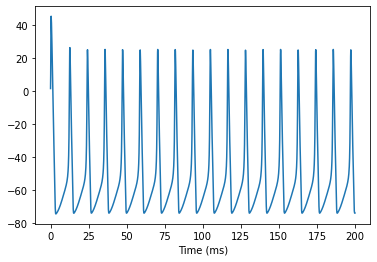

In [27]:
runner(200)  # the running time is 200 ms
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)

A LIF neural group can be instantiated and applied in simulation in a similar way:

Compilation used 0.0050 s.
Start running ...
Run 25.0% used 1.801 s.
Run 50.0% used 3.572 s.
Run 75.0% used 5.353 s.
Run 100.0% used 7.125 s.
Simulation is done in 7.125 s.



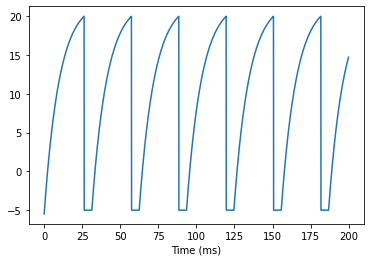

In [28]:
group = LIF(10)
runner = bp.ReportRunner(group, monitors=['V'], inputs=('input', 22.), report=0.25)
runner(200)
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)